# Decision Tree Model

In [1]:
execution_mode = 'restricted'

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Decision-Tree Classifier](#Decision-Tree-Classifier)
    - [Train/Test Split for Decision Tree](#Train/Test-Split-for-Decision-Tree)
    - [Model Training for Decision Tree](#Model-Training-for-Decision-Tree)
    - [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree)
- [Decision Tree Classifier with Cross-Validation](#Decision-Tree-Classifier-with-Cross-Validation)
    - [Train/Test Split for Decision Tree CV](#Train/Test-Split-for-Decision-Tree-CV)
    - [Model Training for Decision Tree CV](#Model-Training-for-Decision-Tree-CV)
    - [Performance Measurement of Decision Tree CV](#Performance-Measurement-of-Decision-Tree-CV)
- [Random Forests](#Random-Forests)
    - [Train/Test Split for Random Forests](#Train/Test-Split-for-Random-Forests)
    - [Model Training for Random Forests](#Model-Training-for-Random-Forests)
    - [Performance Measurement of Random Forests](#Performance-Measurement-of-Random-Forests)
- [Results Handover](#Results-Handover)

## Data Takeover

Read in DataFrame from chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb) as input for processing in this chapter.

In [2]:
import os
import pandas as pd

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

df_attribute_with_sim_feature = pd.read_pickle(os.path.join(
    path_goldstandard, 'labelled_feature_matrix_full.pkl'), compression=None
                                              )

df_labelled_feature_matrix.head()

duplicates  coordinate_E_delta  coordinate_N_delta  corporate_full_delta  \
0           1                -0.1                -0.1                  -0.1   
1           1                -0.1                -0.1                  -0.1   
2           1                -0.1                -0.1                  -0.1   
3           1                -0.1                -0.1                  -0.1   
4           1                -0.1                -0.1                  -0.1   

   doi_delta  edition_delta  exactDate_delta  format_postfix_delta  \
0       -0.1           -0.1             0.75                   1.0   
1       -0.1           -0.1             0.75                   1.0   
2       -0.1           -0.1             0.75                   1.0   
3       -0.1           -0.1             0.75                   1.0   
4       -0.1           -0.1             0.75                   1.0   

   format_prefix_delta  isbn_delta  ...  musicid_delta  part_delta  \
0                  1.0         1.0  ...           -0.1         1.0   
1                  1.0         1.0  ...           -0.1         1.0   
2                  1.0         1.0  ...           -0.1         1.0   
3                  1.0         1.0  ...           -0.1         1.0   
4                  1.0         1.0  ...           -0.1         1.0   

   person_100_delta  person_245c_delta  person_700_delta  pubinit_delta  \
0               1.0           1.000000              1.00       1.000000   
1               1.0           0.818905             -0.05       0.848485   
2               1.0           0.697740             -0.05       0.848485   
3               1.0           0.818905             -0.05       0.848485   
4               1.0           1.000000             -0.10       1.000000   

   scale_delta  ttlfull_245_delta  ttlfull_246_delta  volumes_delta  
0         -0.1           1.000000               -0.1            1.0  
1         -0.1           0.787879               -0.1            1.0  
2         -0.1           1.000000               -0.1            1.0  
3         -0.1           0.787879               -0.1            1.0  
4         -0.1           1.000000               -0.1            1.0  

[5 rows x 21 columns]

In [10]:
print('Number of duplicates (1) and uniques (0)')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=False))
print('Ratio of duplicates (1) on uniques (0) in units of [%]')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100)

Number of duplicates (1) and uniques (0)
0    259260
1      1473
Name: duplicates, dtype: int64
Ratio of duplicates (1) on uniques (0) in units of [%]
0    99.435054
1     0.564946
Name: duplicates, dtype: float64


## Decision Tree Classifier

Decision Tree is the most basic algorithm in the family of Ensemble methods.

### Train/Test Split for Decision Tree

The train/test split has been implemented as a general function $\texttt{.split}\_\texttt{feature}\_\texttt{target}()$. The function uses the library function $\texttt{sklearn.model}\_\texttt{selection.train}\_\texttt{test}\_\texttt{split}()$ from scikit-learn with a $\texttt{stratify}$ parameter in order to generate a balanced distribution of the two classes in the split data, the same as in the original distribution.

The train/test split is done twice. The first split generates an intermediate set of train data which consists of 80% and a set of test data which consists of 20% of the full data. The second split takes the intermediate train data as its basis and extracts an 80% set out of there which will be used for training the model. The remaining 20% out of the intermediate train data will be used for validating the model during training. This strict separation of the data used for training and used for validating the model conforms to the basic principle of machine learning that any model is to be tested with unseen data. If this principle is hurt and the test data is polluted with data, the model has been in contact with during training phase, the model runs the risk of bias.

In [4]:
import classifier_fitting_funcs as cff

X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, idx_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -0.5       ,
          0.875     ,  0.11111111,  0.        ,  0.        , -0.5       ,
         -1.        , -0.5       , -0.5       ,  0.62924468,  0.59952107,
          0.43923445, -1.        ,  0.50681575, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          1.        ,  1.        ,  1.        ,  1.        , -1.        ,
          1.        , -1.        ,  1.        ,  0.86802386,  0.9852439 ,
          0.94444444, -1.        ,  0.94145658, -1.        ,  1.        ],
        [-0.5       , -0.5       , -0.5       , -1.        , -1.        ,
          0.375     ,  0.11111111,  0.        ,  1.        , -1.        ,
         -1.        , -0.5       , -1.        ,  0.52486434,  0.49253561,
         -0.5       , -0.5       ,  0.46222222, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.75      ,  0.42857143, 

In [5]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)

(191512, 20) (191512,) (47878, 20) (47878,) (59848, 20) (59848,)


### Model Training for Decision Tree

In [6]:
if execution_mode == 'full' :
    # Find best parameters of Decision Tree
    depths = list(range(1, 31))
    depths.extend([35, 40, 45, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini', 'entropy'],
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = list(range(1, 31, 2))
    depths.extend([35, 40, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini'],
        'class_weight' : ['balanced']
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
max_depth [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 35, 40, 50, None]
criterion ['gini']
class_weight ['balanced']
 => Number of combinations : 19


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(dt, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_dt = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1}
 => validation score 97.692%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}
 => validation score 99.058%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5}
 => validation score 99.162%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7}
 => validation score 99.724%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9}
 => validation score 99.850%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 11}
 => validation score 99.856%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13}
 => validation score 99.900%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15}
 => validation score 99.896%
Fitting with parameters {'class_weight': 'bal

In [8]:
ts_dict = {}

for kow in parameter_dictionary['class_weight']:
    ts_dict['unbalanced' if kow is None else kow] = [
        ts for ts in test_scores if ts['class_weight'] == kow]

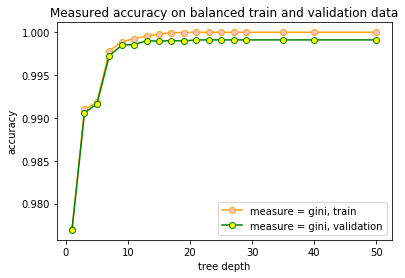

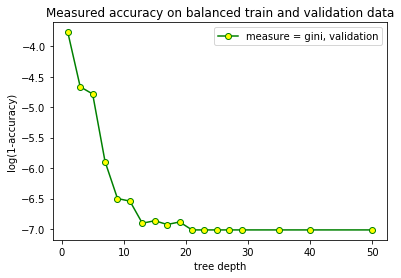

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import results_saving_funcs as rsf

for kow in parameter_dictionary['class_weight'] :
    kind_of_weight = 'unbalanced' if kow is None else kow
    # Train data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_tr')
    # Validation data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_val')
    plt.ylabel('accuracy')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()
    
    # Validation data plot
    plt = rsf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'log_accuracy_val')
    plt.ylabel('log(1-accuracy)')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()

In [10]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

dt_best = DecisionTreeClassifier(criterion=best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'], random_state=0)

dt_best.fit(X_tr, y_tr)
y_pred_dt = dt_best.predict(X_te)

The parameters for the best model are ...
max_depth = 21
criterion = gini
class_weight = balanced


In [11]:
! pip install graphviz

In [12]:
path_tree_graphics = './documentation'

# Path for Decision Tree
decision_tree_dot = os.path.join(path_tree_graphics, 'decision_tree.dot')
decision_tree_png = os.path.join(path_tree_graphics, 'decision_tree.png')

from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt_best, out_file=decision_tree_dot,
    feature_names=df_labelled_feature_matrix.drop(columns=['duplicates']).columns,
    class_names=['unique', 'duplicate'],
    filled=True, rounded=True, proportion=True
)

# Generate image in .png format
! dot -Tpng $decision_tree_dot -o $decision_tree_png

In [13]:
from IPython.display import Image
Image(decision_tree_png)

### Performance Measurement of Decision Tree

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_pred_dt)

array([[51835,    17],
       [   26,  7970]])

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('Score {:.1f}%'.format(100*dt_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_dt),
                100*accuracy_score(y_te, y_pred_dt),
                100*precision_score(y_te, y_pred_dt),
                100*recall_score(y_te, y_pred_dt)
               ))

Score 99.9%
Area under the curve 99.8% - accuracy 99.9% - precision 99.8% - recall 99.7%


In [16]:
import results_analysis_funcs as raf

In [17]:
df_feature_base_full_tr = df_attribute_with_sim_feature.iloc[idx_tr]
df_feature_base_full_te = df_attribute_with_sim_feature.iloc[idx_te]

# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_feature_base_full_te.columns)

df_feature_base_full_te.sort_index().sample(n=10)

duplicates  coordinate_E_delta coordinate_E_x coordinate_E_y  \
72372            0                -1.0                                 
277540           1                -1.0                                 
261791           1                -1.0                                 
277398           1                -1.0                                 
241283           0                -1.0                                 
156729           0                -1.0                                 
272327           1                -1.0                                 
243084           0                -1.0                                 
255072           0                -1.0                                 
293908           1                -1.0                                 

        coordinate_N_delta coordinate_N_x coordinate_N_y  \
72372                 -1.0                                 
277540                -1.0                                 
261791                -1.0                                 
277398                -1.0                                 
241283                -1.0                                 
156729                -1.0                                 
272327                -1.0                                 
243084                -1.0                                 
255072                -1.0                                 
293908                -1.0                                 

        corporate_full_delta  \
72372              -1.000000   
277540             -1.000000   
261791             -1.000000   
277398              0.866667   
241283             -0.500000   
156729             -1.000000   
272327             -1.000000   
243084             -1.000000   
255072             -1.000000   
293908             -1.000000   

                                         corporate_full_x  \
72372                                                       
277540                                                      
261791                                                      
277398  interkantonale lehrmittelzentrale (rapperswil,...   
241283                                        oper (köln)   
156729                                                      
272327                                                      
243084                                                      
255072                                                      
293908                                                      

                                         corporate_full_y  doi_delta doi_x  \
72372                                                           -1.0         
277540                                                          -1.0         
261791                                                          -1.0         
277398  interkantonale lehrmittelzentrale (rapperswil,...       -1.0         
241283                                                          -1.0         
156729                                                          -1.0         
272327                                                          -1.0         
243084                                                          -1.0         
255072                                                          -1.0         
293908                                                          -1.0         

       doi_y  edition_delta edition_x edition_y  exactDate_delta exactDate_x  \
72372                  -0.5         8                      0.750    2011uuuu   
277540                 -1.0                                1.000    1971uuuu   
261791                  1.0         2         2            1.000    2000uuuu   
277398                 -1.0                                1.000    2002uuuu   
241283                 -1.0                                0.625    19911794   
156729                 -1.0                                0.750    uuuuuuuu   
272327                 -1.0                                1.000    1990uuuu   
243084                 -1.0   

In [18]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dt)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dt, i, df_feature_base_full_te.loc[idx[i]])

## Decision Tree Classifier with Cross-Validation

In order to reach a model with a strong statistical stability, cross-validation can be used when training the model. This section will use an object $\texttt{GridSearchCV}$ from scikit-learn for this purpose.

### Train/Test Split for Decision Tree CV

When doing cross-validation, the training data is split into training and validation data by the $\texttt{GridSearchCV}$ object from scikit-learn. Therefore, it is sufficient to split the original data into a train and a test data set without any additional splitting of the train data.

In [19]:
X_tr, _, X_te, y_tr, _, y_te, idx_tr, _, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  0.11111111,  0.        ,  1.        , -1.        ,
         -0.5       , -1.        , -0.5       ,  0.54319292,  0.39954955,
         -0.5       , -1.        ,  0.54733045, -1.        ,  0.75      ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.5       ,  0.11111111,  0.        ,  0.        , -1.        ,
         -0.5       , -1.        ,  0.68790469,  0.60654762,  0.44685185,
          0.59968652, -1.        ,  0.52362057, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.8125    ,  0.11111111,  0.        ,  0.        , -1.        ,
         -0.5       , -0.5       , -0.5       ,  0.62200855, -0.5       ,
          0.36243386, -1.        ,  0.60337302, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -0.5       ,
          0.5       ,  0.42857143, 

In [20]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(239390, 20) (239390,) (59848, 20) (59848,)


### Model Training for Decision Tree CV

The grid search for Decision Tree classifier with cross-validation will be done with the same parameter space like for Decision Tree classifier without cross-validation. In this way, the effect of cross-validation will become obvious.

In [21]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create cross-validation object with DecisionTreeClassifer
grid_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
                       param_grid = parameter_dictionary, cv=5
                       , verbose=1
                      )

# Fit estimator
grid_cv.fit(X_tr, y_tr)

# Get the results with 'cv_results_', get parameters with their scores
params = pd.DataFrame(grid_cv.cv_results_['params'])
scores = pd.DataFrame(grid_cv.cv_results_['mean_test_score'], columns=['accuracy_val'])
log_scores = pd.DataFrame(np.log(1-grid_cv.cv_results_['mean_test_score']), columns=['log_accuracy_val'])
scores_std = pd.DataFrame(grid_cv.cv_results_['std_test_score'], columns=['std_accuracy_val'])

# Create a DataFrame of (parameters, score, std) pairs
df_test_scores_dtcv = params.merge(scores, how='inner', left_index=True, right_index=True)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    scores_std, how='inner', left_index=True, right_index=True).sort_values(
    'accuracy_val', ascending=False)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    log_scores, how='inner', left_index=True, right_index=True)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  1.5min finished


In [22]:
df_test_scores_dtcv

class_weight criterion  max_depth  accuracy_val  std_accuracy_val  \
18     balanced      gini        NaN      0.998935          0.000152   
17     balanced      gini       50.0      0.998935          0.000152   
16     balanced      gini       40.0      0.998935          0.000152   
15     balanced      gini       35.0      0.998935          0.000152   
14     balanced      gini       29.0      0.998935          0.000152   
13     balanced      gini       27.0      0.998935          0.000152   
12     balanced      gini       25.0      0.998935          0.000152   
11     balanced      gini       23.0      0.998935          0.000152   
10     balanced      gini       21.0      0.998931          0.000150   
8      balanced      gini       17.0      0.998897          0.000145   
9      balanced      gini       19.0      0.998880          0.000133   
7      balanced      gini       15.0      0.998839          0.000182   
6      balanced      gini       13.0      0.998776          0.000261   
5      balanced      gini       11.0      0.998530          0.000227   
4      balanced      gini        9.0      0.998258          0.000235   
3      balanced      gini        7.0      0.997247          0.000288   
2      balanced      gini        5.0      0.991625          0.000275   
1      balanced      gini        3.0      0.990789          0.000294   
0      balanced      gini        1.0      0.976766          0.000699   

    log_accuracy_val  
18         -6.844586  
17         -6.844586  
16         -6.844586  
15         -6.844586  
14         -6.844586  
13         -6.844586  
12         -6.844586  
11         -6.844586  
10         -6.840672  
8          -6.809900  
9          -6.794862  
7          -6.758228  
6          -6.705677  
5          -6.522218  
4          -6.352763  
3          -5.895126  
2          -4.782450  
1          -4.687367  
0          -3.762136

In [23]:
dtcv_best = grid_cv.best_estimator_
y_pred_dtcv = dtcv_best.predict(X_te)

### Performance Measurement of Decision Tree CV

In [24]:
confusion_matrix(y_te, y_pred_dtcv)

array([[51835,    17],
       [   24,  7972]])

In [25]:
print('Score {:.1f}%'.format(100*dtcv_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_dtcv),
                100*accuracy_score(y_te, y_pred_dtcv),
                100*precision_score(y_te, y_pred_dtcv),
                100*recall_score(y_te, y_pred_dtcv)
               ))

Score 99.9%
Area under the curve 99.8% - accuracy 99.9% - precision 99.8% - recall 99.7%


In [26]:
df_feature_base_full_tr = df_attribute_with_sim_feature.iloc[idx_tr]
df_feature_base_full_te = df_attribute_with_sim_feature.iloc[idx_te]

# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_feature_base_full_te.columns)

df_feature_base_full_te.sort_index().sample(n=10)

duplicates  coordinate_E_delta coordinate_E_x coordinate_E_y  \
296817           1                -1.0                                 
69371            0                -1.0                                 
270419           1                -1.0                                 
136565           0                -1.0                                 
274382           1                -1.0                                 
23710            0                -1.0                                 
36552            0                -1.0                                 
80096            0                -1.0                                 
134360           0                -1.0                                 
27578            0                -1.0                                 

        coordinate_N_delta coordinate_N_x coordinate_N_y  \
296817                -1.0                                 
69371                 -1.0                                 
270419                -1.0                                 
136565                -1.0                                 
274382                -1.0                                 
23710                 -1.0                                 
36552                 -1.0                                 
80096                 -1.0                                 
134360                -1.0                                 
27578                 -1.0                                 

        corporate_full_delta  \
296817                  -1.0   
69371                   -1.0   
270419                  -1.0   
136565                  -1.0   
274382                  -1.0   
23710                   -1.0   
36552                   -1.0   
80096                   -1.0   
134360                  -0.5   
27578                   -0.5   

                                         corporate_full_x  corporate_full_y  \
296817                                                                        
69371                                                                         
270419                                                                        
136565                                                                        
274382                                                                        
23710                                                                         
36552                                                                         
80096                                                                         
134360  metropolitan opera (new york)orchestra, metrop...                     
27578                                                      arts florissants   

        doi_delta doi_x doi_y  edition_delta edition_x edition_y  \
296817       -1.0                       -1.0                       
69371        -1.0                       -0.5         2             
270419       -1.0                       -1.0                       
136565       -1.0                       -1.0                       
274382       -1.0                       -1.0                       
23710        -1.0                       -1.0                       
36552        -1.0                       -1.0                       
80096        -1.0                       -1.0                       
134360       -1.0                       -1.0                       
27578        -1.0                       -1.0                       

        exactDate_delta exactDate_x exactDate_y  format_postfix_delta  \
296817            1.000    19959999    19959999              1.000000   
69371             0.750    uuuuuuuu    1989uuuu              0.428571   
270419            1.000    20081991    20081991              1.000000   
136565            0.500    1764uuuu    2015uuuu              1.000000   
274382            1.000    19951997    19951997              1.000000   
23710             0.500    2005uuuu    1970uuuu              0.111111   
36552             0.750    uuuuuuuu    2017uuuu              0.111111  

In [27]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dtcv)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dtcv_best, i, df_feature_base_full_te.loc[idx[i]], '_CV')

## Random Forests

Another Ensemble method is Random Forests.

### Train/Test Split for Random Forests

The train/test split for Random Forests will be done the same way like for the Decision Tree classifier.

In [28]:
X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, id_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -0.5       ,
          0.875     ,  0.11111111,  0.        ,  0.        , -0.5       ,
         -1.        , -0.5       , -0.5       ,  0.62924468,  0.59952107,
          0.43923445, -1.        ,  0.50681575, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          1.        ,  1.        ,  1.        ,  1.        , -1.        ,
          1.        , -1.        ,  1.        ,  0.86802386,  0.9852439 ,
          0.94444444, -1.        ,  0.94145658, -1.        ,  1.        ],
        [-0.5       , -0.5       , -0.5       , -1.        , -1.        ,
          0.375     ,  0.11111111,  0.        ,  1.        , -1.        ,
         -1.        , -0.5       , -1.        ,  0.52486434,  0.49253561,
         -0.5       , -0.5       ,  0.46222222, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.75      ,  0.42857143, 

In [29]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(191512, 20) (191512,) (59848, 20) (59848,)


### Model Training for Random Forests

In [30]:
if execution_mode == 'full' :
    # Tune random forest classifier
    depths = list(range(10, 25))
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [8, 10, 25, 40, 50, 75, 100],
        'max_depth' : depths,
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = list(range(20, 22, 24))
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [75, 100],
        'max_depth' : depths,
        'class_weight' : [None]
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
n_estimators [10, 50]
max_depth [15, 16, 17, None]
class_weight ['balanced']
 => Number of combinations : 8


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest
rf = RandomForestClassifier(random_state=0) # Leave impurty measure on default value 'gini'

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(rf, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_rf = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 10}
 => validation score 99.923%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 50}
 => validation score 99.925%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 10}
 => validation score 99.921%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 50}
 => validation score 99.933%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 10}
 => validation score 99.939%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 50}
 => validation score 99.942%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 10}
 => validation score 99.939%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 50}
 => validation score 99.950%


In [32]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

# Create a decision tree
rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'],
                                 random_state=0
                                )

# Fit estimator
rf_best.fit(X_tr, y_tr)
y_pred_rf = rf_best.predict(X_te)

The parameters for the best model are ...
n_estimators = 50
max_depth = None
class_weight = balanced


For Random Forests an attribute is provided which returns an array, indicating the feature importances. The higher the value, the more important the feature.

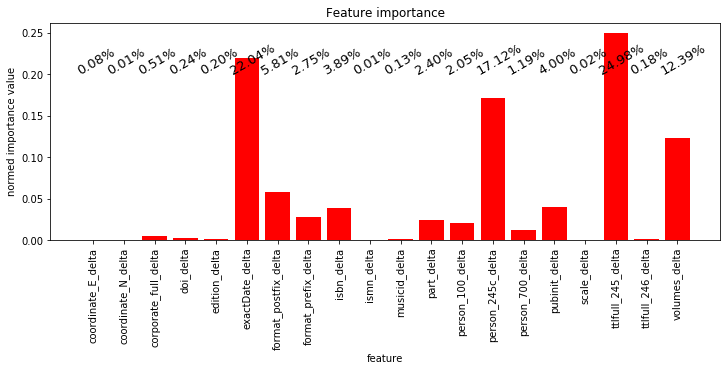

In [33]:
x_ticks = df_labelled_feature_matrix.drop(columns=['duplicates']).columns

plt.figure(figsize=(12,4))
plt.bar(x_ticks, rf_best.feature_importances_, color='red')
for i in range(len(x_ticks)):
    plt.text(i-0.6, 2/10, f'{rf_best.feature_importances_[i]*100:.2f}%',
             color='black', rotation=30, fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Feature importance')
plt.xlabel('feature')
plt.ylabel('normed importance value')
plt.show()

### Performance Measurement of Random Forests

In [34]:
confusion_matrix(y_te, y_pred_rf)

array([[51840,    12],
       [   14,  7982]])

In [35]:
print('Score {:.1f}%'.format(100*rf_best.score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(
    100*roc_auc_score(y_te, y_pred_rf),
                100*accuracy_score(y_te, y_pred_rf),
                100*precision_score(y_te, y_pred_rf),
                100*recall_score(y_te, y_pred_rf)
               ))

Score 100.0%
Area under the curve 99.9% - accuracy 100.0% - precision 99.8% - recall 99.8%


In [36]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_rf)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              rf, i, df_feature_base_full_te.loc[idx[i]])

## Results Handover

The final results will be assessed with the help of the same test data for all three models of this chapter. The train/test split will not be repeated here, as all train/test split calls of this chapter have generated the same test data set, due to fixing $\texttt{random}\_\texttt{state}=0$.

In [37]:
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_dt, dt_best, X_te, y_te, y_pred_dt)
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_dtcv, dtcv_best, X_te, y_te, y_pred_dtcv, '_CV')
rsf.add_result_to_results(path_goldstandard,
                          df_test_scores_rf, rf_best, X_te, y_te, y_pred_rf)